![Logo.png](Images/Logo.png)


# 1. Setup

## 1.1 Import Packages

In [1]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score,silhouette_samples

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
# Define a simple scoring function
from cachetools import cached

## 1.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 1.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

locations= session.table("frostbyte_tasty_bytes.raw_pos.location")

menu= session.table("frostbyte_tasty_bytes.raw_pos.menu")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("ngee_ann_polytechnic_frostbyte_data_share.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 2. Data Exploration 

## 2.0 Model Value Towards Tasty Byte KPI

### 2.0.1 Define function - Remove Duplicate Columns from Joins

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

# 3. Data Engineering

## 3.1 Generate new Columns

In [6]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)

In [7]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

### 3.1.1 Get Latest Order Date

In [8]:
# called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')


In [9]:
# Rename columns
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [10]:
# Merge with second max order dataframe
max_Order=remove_dup.join(right=max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = max_Order.filter(F.col('ORDER_TS') < F.col('Max_Order_TS'))


In [11]:
# Display last recorded purchase globally
filtered_df.select(F.max('ORDER_TS')).show()

-----------------------
|"MAX(""ORDER_TS"")"  |
-----------------------
|2022-10-31 22:54:37  |
-----------------------



We got the latest order date to filter out the last purchase and its also used to get the days to next order. Since our target variable is closely related to the days to next order, we filter out the last purchase to not leak future information such that we are able to prevent target leakage.

### 3.1.2 RFM (Recency, Freqency, Monetary)

In [12]:
# Get last purchase date as a variable
lastdate=filtered_df.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')


This code is used to get RFM, Recency, Frequency, and Monetary for each customer. The purpose of doing this is to generate new features and show the customer's behavioural data.

### 3.1.3 Average Time Difference, Max and Min Days without Purchase

In [13]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer 
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

# Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

This code is used to get the average purchase time difference for each customers. This is done by calculating the most number of days a customer has gone without purchasing and the least number of days the customer has gone without purchasing. These features are also to show the behavioural information of each customer.

### 3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country

In [14]:
# Get Customer demographic
cust_demo=tasty_bytes_customer_loyalty.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS','COUNTRY','CITY','SIGN_UP_DATE','CHILDREN_COUNT')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

# Show
cust_demo.show()

---------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"  |"COUNTRY"  |"CITY"          |"SIGN_UP_DATE"  |"CHILDREN_COUNT"  |"AGE"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|1              |1953-12-01       |Female       |Single            |Germany    |Hamburg         |2019-02-19      |0                 |69     |
|2              |1973-09-21       |Male         |Single            |Brazil     |Rio de Janeiro  |2019-10-07      |0                 |49     |
|3              |2000-09-04       |Female       |Married           |Poland     |Krakow          |2020-09-11      |2                 |22     |
|4              |1950-03-05       |Female       |Single            |Poland     |Krakow          |2021-09-09      |1                 |72     |
|5    

We added a new column called "AGE" which contains the age of the customer at the time of the latest transaction. We also retrieved new columns like the customer's gender, marital status and country.

### Attempted Improvements to the model

#### Improved the Model

In [15]:
# Number of locations visited
num_of_locations_visited=filtered_df.group_by('CUSTOMER_ID').agg(F.countDistinct('LOCATION_ID').alias('NUM_OF_LOCATIONS_VISITED'))

In [16]:
# Add Length of relationship

window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').asc())

orders_with_rank = filtered_df.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
first_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

# Join the first_orders and last_orders DataFrames on customer_id
joined_orders = first_order_ts.join(max_order_ts, 'customer_id')

# Calculate the difference in days between the first and last order
diff_in_days = joined_orders.withColumn('Length_of_Relationship', F.datediff(col1='order_ts', col2='max_order_ts',part='day'))

diff_in_days=diff_in_days.drop(['ORDER_TS','MAX_ORDER_TS'])

diff_in_days.show()

--------------------------------------------
|"CUSTOMER_ID"  |"LENGTH_OF_RELATIONSHIP"  |
--------------------------------------------
|124719         |1262                      |
|212564         |1175                      |
|164235         |999                       |
|43024          |1271                      |
|191120         |1032                      |
|125591         |1011                      |
|24741          |1262                      |
|195672         |1020                      |
|195177         |817                       |
|194559         |1194                      |
--------------------------------------------



### 3.1.5 Join Generated Variables

In [17]:
# Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(diff_in_days,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(num_of_locations_visited,on='CUSTOMER_ID',how='inner')

We joined all the different tables to get all the columns in the same table by inner joining all the different tables on the CUSTOMER_ID column. The joined table contains all the different features we will be using to predict the target.

#### Attempted Improvement: Created Relative Purchase Frequency and Monetary

In [18]:
final_df=final_df.with_column('RELATIVE_PURCHASE_FREQUENCY',(F.col('FREQUENCY')/F.col('Length_of_Relationship')).cast('float'))
final_df=final_df.with_column('RELATIVE_PURCHASE_MONETARY',(F.col('MONETARY')/F.col('Length_of_Relationship')).cast('float'))

### 3.1.6 Days to Next Order

In [19]:
# Convert timestamp to date such that Days to next orders is more accurate
final_df=final_df.with_column('ORDER_TS',F.to_date(F.col('ORDER_TS')))
final_df=final_df.with_column('MAX_ORDER_TS',F.to_date(F.col('MAX_ORDER_TS')))

In [20]:
# Add Days To Next Order
final_df = final_df.withColumn('Days_To_Next_Order', F.datediff(col1=final_df['ORDER_TS'], col2=final_df['MAX_ORDER_TS'],part='day'))

In [21]:
# Get median of Days to next order
final_df.select(F.median('DAYS_TO_NEXT_ORDER')).show()

------------------------------------
|"MEDIAN(""DAYS_TO_NEXT_ORDER"")"  |
------------------------------------
|9.000                             |
------------------------------------



We use the median number of days since the prior order for the global dataset to create a target variable that distinguishes customers who purchase below or above this median. Customers who purchase below the median will be labeled as 'Not churn', while those who purchase above the median will be labeled as 'Churn'. This approach will help us identify customers who may require retention strategies and predict their level of engagement with our business.

The median days to next order is 9 for customers from all countries, this will be used to check if our train dataset's target variable is representative of the global dataset.

### 3.1.7 Filter to selected Country

In [22]:
# Filter to United States
final_df=final_df.filter(F.col('COUNTRY')=='United States')

We filtered the data to only have records for the United States. This is because we are only interested in the United States as shown above due to its high churn rate and high number of customers

In [23]:
# Sort CustomerID
final_df=final_df.sort('CUSTOMER_ID')

In [24]:
# Convert to pandas
final_df=final_df.to_pandas()

In [25]:
final_df

,CUSTOMER_ID,RECENCY,FREQUENCY,MONETARY,AVG_DAYS_BETWEEN_PURCHASE,MAX_DAYS_WITHOUT_PURCHASE,MIN_DAYS_WITHOUT_PURCHASE,BIRTHDAY_DATE,GENDER,MARITAL_STATUS,...,SIGN_UP_DATE,CHILDREN_COUNT,AGE,LENGTH_OF_RELATIONSHIP,NUM_OF_LOCATIONS_VISITED,RELATIVE_PURCHASE_FREQUENCY,RELATIVE_PURCHASE_MONETARY,ORDER_TS,MAX_ORDER_TS,DAYS_TO_NEXT_ORDER
0,22,14,43,1404.50,30,173,1,1949-01-12,Male,Married,...,2021-04-22,4,73,1253,40,0.034318,1.120910,2022-10-17,2022-10-19,2
1,42,8,39,1811.50,33,167,1,1966-06-28,Undisclosed,Single,...,2020-07-11,0,56,1270,36,0.030709,1.426378,2022-10-23,2022-10-26,3
2,59,26,38,1256.50,33,390,1,1961-06-05,Male,Married,...,2020-12-29,2,61,1260,35,0.030159,0.997222,2022-10-05,2022-10-26,21
3,65,29,42,1393.25,30,207,2,1958-09-01,Male,Divorced/Seperated,...,2020-11-05,5+,64,1222,40,0.034370,1.140139,2022-10-02,2022-10-13,11
4,106,18,48,2096.75,24,158,1,1967-05-10,Female,Single,...,2021-06-28,0,55,1133,47,0.042365,1.850618,2022-10-13,2022-10-29,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46295,199985,19,66,2576.50,16,54,1,1944-01-13,Female,Married,...,2021-01-19,2,78,1028,60,0.064202,2.506323,2022-10-12,2022-10-23,11
46296,199991,4,57,2185.50,18,107,1,1958-09-26,Female,Married,...,2020-06-07,1,64,1034,54,0.055126,2.113636,2022-10-27,2022-10-31,4
46297,199995,59,36,1297.75,24,125,1,1944-08-03,Undisclosed,Single,...,2020-01-11,0,78,903,34,0.039867,1.437154,2022-09-02,2022-10-29,57
46298,199999,31,36,1210.50,31,182,1,1972-08-19,Female,Married,...,2021-05-23,2,50,1102,35,0.032668,1.098457,2022-09-30,2022-10-18,18


We converted the table to pandas because we want to carry out data manipulation.

## 3.2 Outlier Handling

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by IQR

In [26]:
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

In [27]:
final_df_win = windsorizer.transform(final_df)

Cap by IQR for distributions with high skewness. (Outliers = 75th percentile onwards)

#### 3.2.3.2 Cap by Gaussian

In [28]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','MONETARY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'MONETARY'])

In [29]:
final_df_win = windsorizer.transform(final_df_win)

### 3.3.2 Generate Churn

In [30]:
# create untransformed copy of the dataframe for customer segmentation
cust_seg_ori = final_df_win.copy()

# Add Target CHURNED
cust_seg_ori['CHURNED'] = 1
cust_seg_ori.loc[cust_seg_ori['DAYS_TO_NEXT_ORDER']<=14,'CHURNED'] = 0

In [31]:
# plots a vertical bar graph of value counts by category, lengend of cluster number
def plot_categorical_distribution(categorical_variable, cluster_variable,custom_palette,df_categoical):
    plt.figure(figsize=(14, 6))
    ax = sns.countplot(data=df_categoical, x=categorical_variable, hue=cluster_variable, palette=custom_palette)
    plt.title(f"Distribution of {categorical_variable} by Clusters")
    plt.xlabel(categorical_variable)
    plt.ylabel("Count")
    plt.legend(title=cluster_variable, loc="upper right")    
    # data labels
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    plt.show()

In [32]:
cust_seg_demo_full=cust_seg_ori.copy()

In [33]:
cust_seg_demo_full

,CUSTOMER_ID,RECENCY,FREQUENCY,MONETARY,AVG_DAYS_BETWEEN_PURCHASE,MAX_DAYS_WITHOUT_PURCHASE,MIN_DAYS_WITHOUT_PURCHASE,BIRTHDAY_DATE,GENDER,MARITAL_STATUS,...,CHILDREN_COUNT,AGE,LENGTH_OF_RELATIONSHIP,NUM_OF_LOCATIONS_VISITED,RELATIVE_PURCHASE_FREQUENCY,RELATIVE_PURCHASE_MONETARY,ORDER_TS,MAX_ORDER_TS,DAYS_TO_NEXT_ORDER,CHURNED
0,22,14,43.0,1404.50,30,173,1,1949-01-12,Male,Married,...,4,73,1253,40,0.034318,1.120910,2022-10-17,2022-10-19,2,0
1,42,8,39.0,1811.50,33,167,1,1966-06-28,Undisclosed,Single,...,0,56,1270,36,0.030709,1.426378,2022-10-23,2022-10-26,3,0
2,59,26,38.0,1256.50,33,355,1,1961-06-05,Male,Married,...,2,61,1260,35,0.030159,0.997222,2022-10-05,2022-10-26,21,1
3,65,29,42.0,1393.25,30,207,2,1958-09-01,Male,Divorced/Seperated,...,5+,64,1222,40,0.034370,1.140139,2022-10-02,2022-10-13,11,0
4,106,18,48.0,2096.75,24,158,1,1967-05-10,Female,Single,...,0,55,1133,47,0.042365,1.850618,2022-10-13,2022-10-29,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46295,199985,19,66.0,2576.50,16,54,1,1944-01-13,Female,Married,...,2,78,1028,60,0.064202,2.506323,2022-10-12,2022-10-23,11,0
46296,199991,4,57.0,2185.50,18,107,1,1958-09-26,Female,Married,...,1,64,1034,54,0.055126,2.113636,2022-10-27,2022-10-31,4,0
46297,199995,59,36.0,1297.75,24,125,1,1944-08-03,Undisclosed,Single,...,0,78,903,34,0.039867,1.437154,2022-09-02,2022-10-29,57,1
46298,199999,31,36.0,1210.50,31,182,1,1972-08-19,Female,Married,...,2,50,1102,35,0.032668,1.098457,2022-09-30,2022-10-18,18,1


In [34]:
cust_seg_demo_full['CHILDREN_COUNT'] = cust_seg_demo_full['CHILDREN_COUNT'].map({
    '0': "No",
    '1': "Yes",
    '2': "Yes",
    '3': "Yes",
    '4': "Yes",
    '5+': "Yes",
    'Undisclosed':'Undisclosed'})

cust_seg_demo_full.rename({'CHILDREN_COUNT':'HAVE_CHILDREN'},inplace=True,errors='ignore',axis=1)

In [35]:
# Define the age groups and corresponding labels
age_bins = [0, 46, 66, 83]
age_labels = ['Adults', 'Middle-Aged Adults', 'Seniors']

# Bin the age column based on the age groups and labels
cust_seg_demo_full['AGE_GROUP'] = pd.cut(cust_seg_demo_full['AGE'], bins=age_bins, labels=age_labels)

In [36]:
# Define the age groups and corresponding labels
DTNO_bins = [0, 7, 14, 30, 999]
DTNO_labels = ['<7 Days', '14 Days', '30 Days', '>30 Days']

# Bin the age column based on the age groups and labels
cust_seg_demo_full['DAYS_TO_NEXT_ORDER'] = pd.cut(cust_seg_demo_full['DAYS_TO_NEXT_ORDER'], bins=DTNO_bins, labels=DTNO_labels)

In [37]:
cust_seg_demo=cust_seg_demo_full[['GENDER','MARITAL_STATUS','CITY','HAVE_CHILDREN','AGE_GROUP']]#,'DAYS_TO_NEXT_ORDER','CHURNED']]
cust_seg_demo

,GENDER,MARITAL_STATUS,CITY,HAVE_CHILDREN,AGE_GROUP
0,Male,Married,San Mateo,Yes,Seniors
1,Undisclosed,Single,San Mateo,No,Middle-Aged Adults
2,Male,Married,San Mateo,Yes,Middle-Aged Adults
3,Male,Divorced/Seperated,San Mateo,Yes,Middle-Aged Adults
4,Female,Single,San Mateo,No,Middle-Aged Adults
...,...,...,...,...,...
46295,Female,Married,Seattle,Yes,Seniors
46296,Female,Married,New York City,Yes,Middle-Aged Adults
46297,Undisclosed,Single,Boston,No,Seniors
46298,Female,Married,San Mateo,Yes,Middle-Aged Adults


In [38]:
def kmodes_eval(cost):
    
    percentage_change = [(cost[i+1] - cost[i]) / cost[i] * 100 for i in range(len(cost)-1)]

    # Define figure size
    plt.figure(figsize=(16, 4))

    # Regular
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), cost, 'b-*')
    plt.title('Actual Cost')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')

    # Difference
    plt.subplot(1, 2, 2)
    plt.plot(range(1, 10), percentage_change, 'b-*')
    plt.title('% change in Cost')
    plt.xlabel('Number of clusters')
    plt.ylabel('% Change')

    plt.suptitle('K-Modes Clustering Elbow Curve')

    plt.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 137532.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 137532.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 137532.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 137532.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 137532.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9333, cost: 100794.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4189, cost: 102899.0
Run 2, iteration: 2/100, moves: 235, cost: 102899.0
Init: init

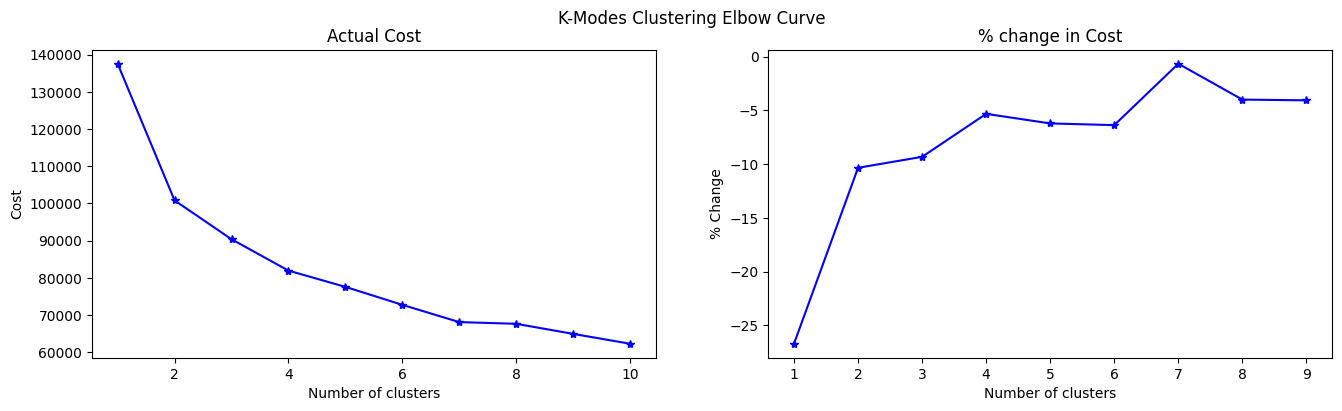

In [39]:
from kmodes.kmodes import KModes
cost = []
for k in range(1, 11):
    kmode = KModes(n_clusters=k, init = "random", n_init = 5, verbose=1)
    kmode.fit(cust_seg_demo)
    cost.append(kmode.cost_)

kmodes_eval(cost)

In [40]:
from kmodes.kmodes import KModes
# Building the model with 3 clusters
kmode = KModes(n_clusters=4, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(cust_seg_demo)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4486, cost: 81637.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 3613, cost: 87427.0
Run 2, iteration: 2/100, moves: 908, cost: 87427.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 11182, cost: 86008.0
Run 3, iteration: 2/100, moves: 2134, cost: 86008.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6044, cost: 86040.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 8869, cost: 81965.0
Best run was number 1


In [41]:
cust_seg_demo['CLUSTERS'] = clusters

C:\Users\kaiyi\AppData\Local\Temp\ipykernel_21616\4045738462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_seg_demo['CLUSTERS'] = clusters


In [42]:
# Define a custom color palette
custom_palette_k_modes = sns.color_palette("tab10", n_colors=4)
custom_palette_k_modes

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

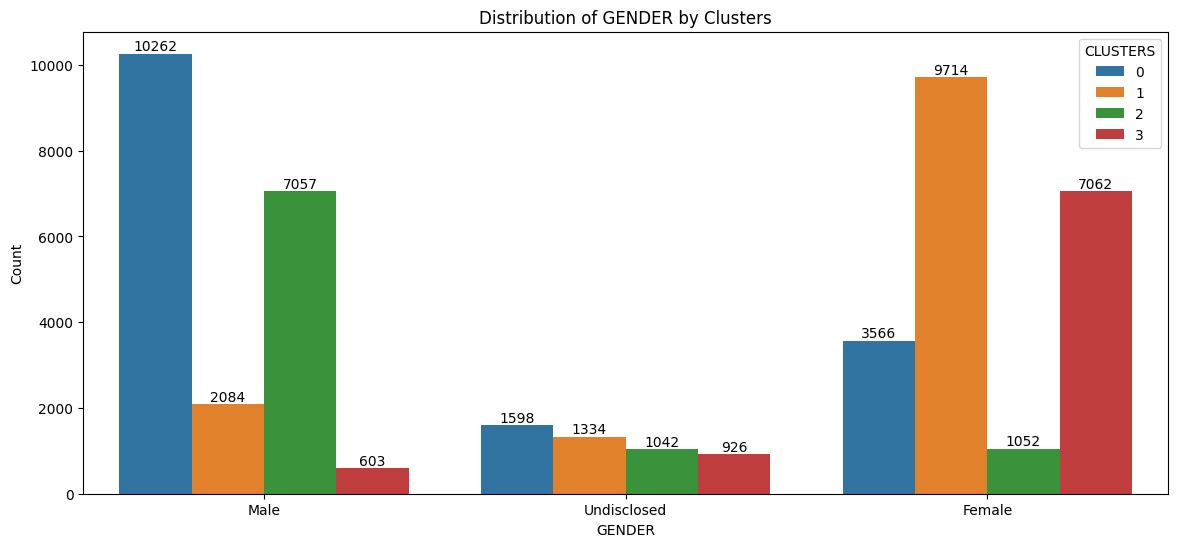

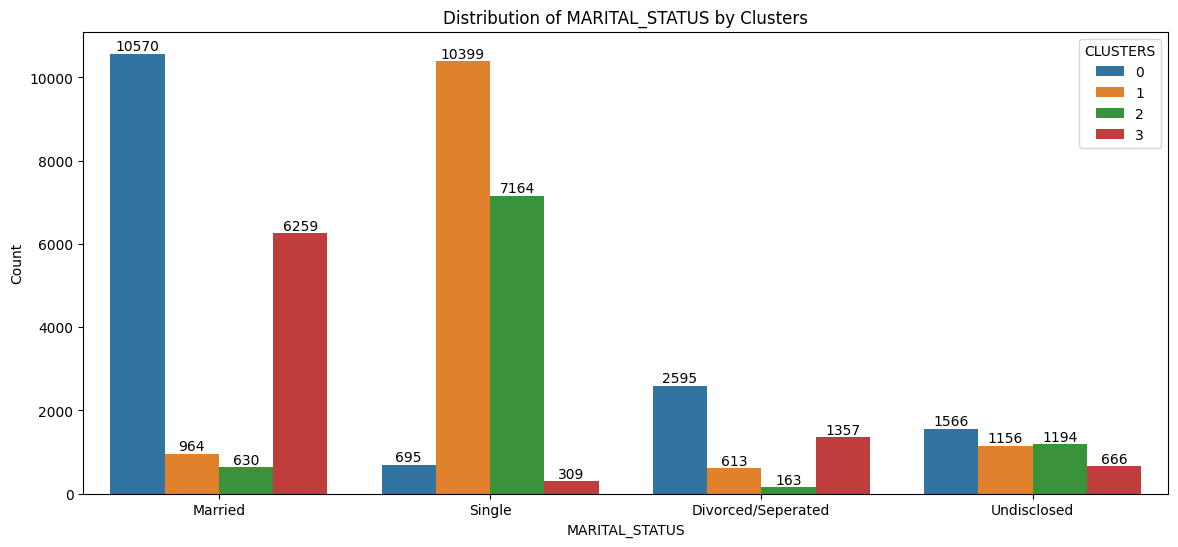

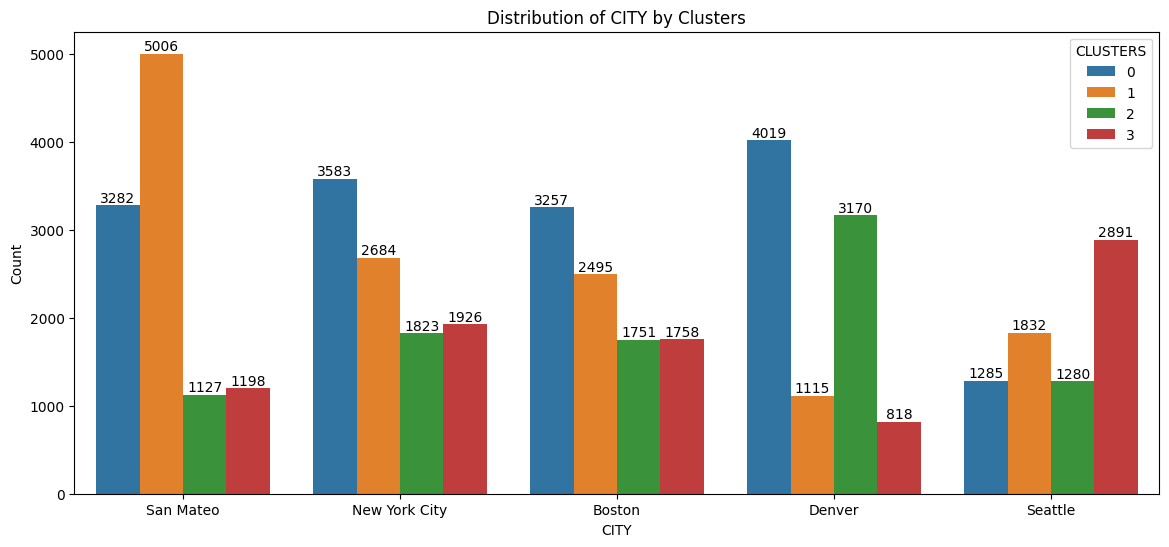

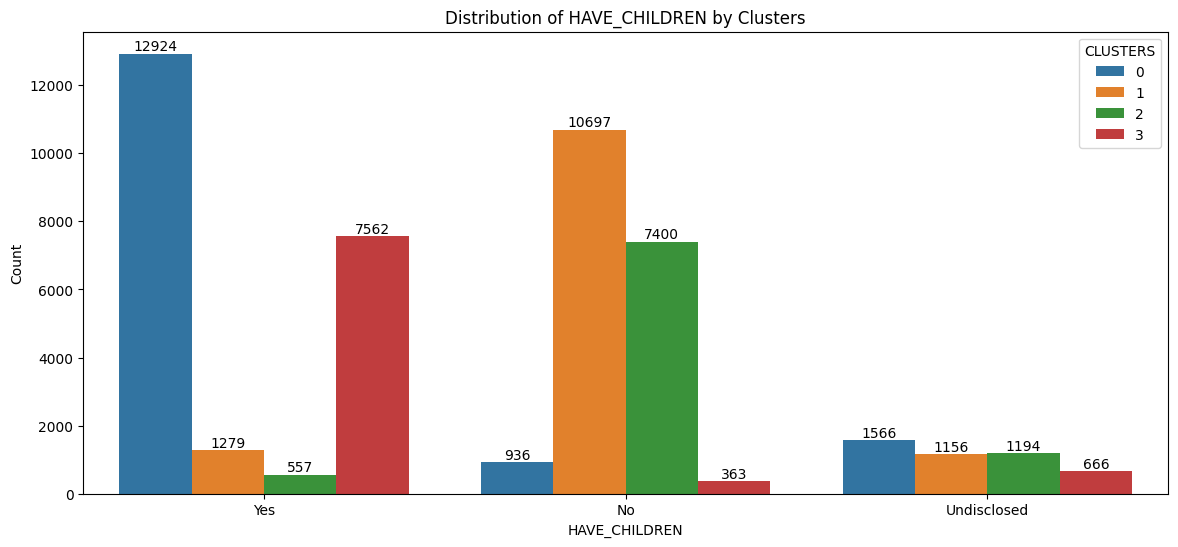

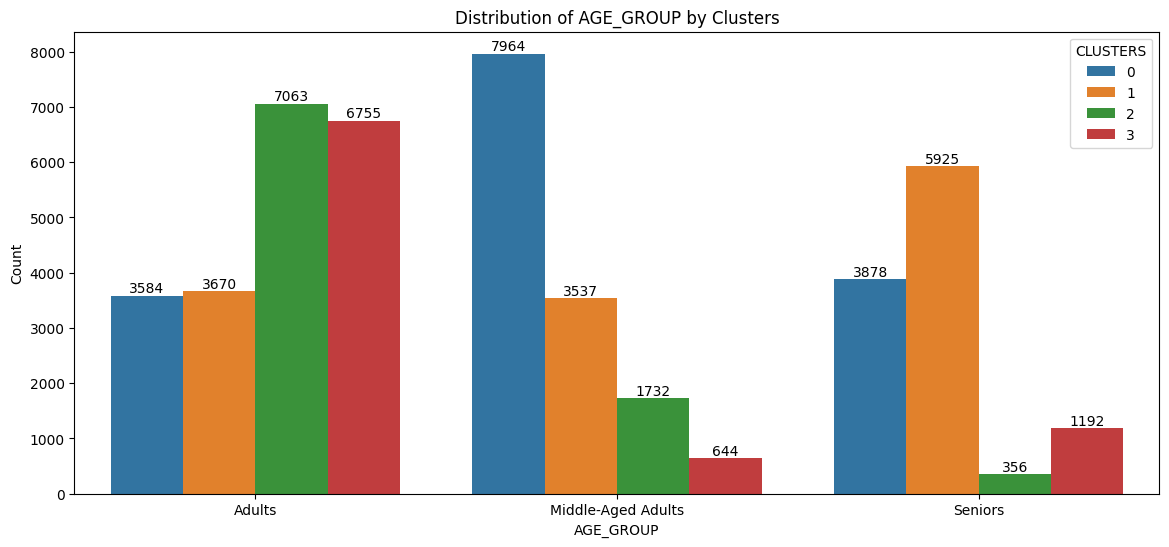

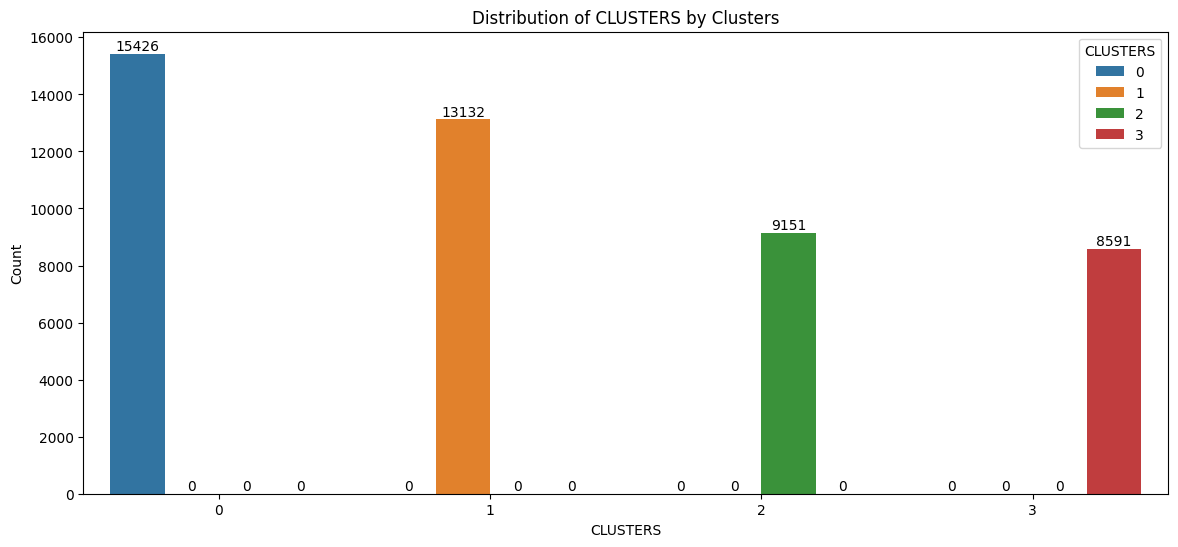

In [43]:
for col in cust_seg_demo.columns:
    plot_categorical_distribution(col, "CLUSTERS", custom_palette_k_modes,cust_seg_demo)

In [44]:
def print_categorical_distribution(categorical_variable, cluster_variable, df_categorical):
    # Group by categorical_variable and cluster_variable, then count the occurrences
    counts = df_categorical.groupby([categorical_variable, cluster_variable]).size().reset_index(name='Count')

    # Iterate through each category and print the value counts by cluster
    for category in counts[categorical_variable].unique():
        print(f"{categorical_variable}: {category}")
        category_counts = counts[counts[categorical_variable] == category]
        for _, row in category_counts.iterrows():
            cluster = row[cluster_variable]
            count = row['Count']
            print(f"Cluster {cluster}: {count} occurrence(s)")
        print()  # Add an empty line between categories


In [45]:
# for col in cust_seg_demo.columns:
#     if col != "CLUSTERS":
#         print_categorical_distribution(col, "CLUSTERS", cust_seg_demo)

In [46]:
cust_seg_demo.columns

Index(['GENDER', 'MARITAL_STATUS', 'CITY', 'HAVE_CHILDREN', 'AGE_GROUP',
       'CLUSTERS'],
      dtype='object')

In [47]:
# Step 1: Group the DataFrame by 'kmeans_cluster'
cluster_groups = cust_seg_demo.groupby('CLUSTERS')

# Step 2: Iterate through each cluster group and apply .info() function
for cluster, cluster_df in cluster_groups:
    print(f"Cluster {cluster} Description:")
    print(cluster_df.describe())
    print("------------")

Cluster 0 Description:
       CLUSTERS
count   15426.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
------------
Cluster 1 Description:
       CLUSTERS
count   13132.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
------------
Cluster 2 Description:
       CLUSTERS
count    9151.0
mean        2.0
std         0.0
min         2.0
25%         2.0
50%         2.0
75%         2.0
max         2.0
------------
Cluster 3 Description:
       CLUSTERS
count    8591.0
mean        3.0
std         0.0
min         3.0
25%         3.0
50%         3.0
75%         3.0
max         3.0
------------


In [48]:
cust_seg_demo['CHURNED'] = cust_seg_demo_full['CHURNED']

C:\Users\kaiyi\AppData\Local\Temp\ipykernel_21616\96624673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_seg_demo['CHURNED'] = cust_seg_demo_full['CHURNED']


In [49]:
cust_seg_demo.groupby('CLUSTERS')['CHURNED'].value_counts()

CLUSTERS  CHURNED
0         0          10875
          1           4551
1         0           8885
          1           4247
2         0           6498
          1           2653
3         0           6066
          1           2525
Name: CHURNED, dtype: int64

In [50]:
cust_seg_demo.groupby('CLUSTERS')['CHURNED'].mean() * 100

CLUSTERS
0    29.502139
1    32.340847
2    28.991367
3    29.391223
Name: CHURNED, dtype: float64

In [51]:
total = 0
for i in range(4):
    total +=cust_seg_demo.groupby('CLUSTERS')['CLUSTERS'].count()[i]

In [52]:
total

46300

In [53]:
for i in range(4):
    print((cust_seg_demo.groupby('CLUSTERS')['CLUSTERS'].count()[i]/total)*100)
    

33.317494600431964
28.36285097192225
19.764578833693307
18.555075593952484


In [54]:
cust_seg_demo['SALES'] = cust_seg_demo_full['MONETARY']

C:\Users\kaiyi\AppData\Local\Temp\ipykernel_21616\4053940899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_seg_demo['SALES'] = cust_seg_demo_full['MONETARY']


In [55]:
total = 0
for i in range(4):
    total +=cust_seg_demo.groupby('CLUSTERS')['SALES'].sum()[i]

In [56]:
total

95077318.60481219

In [57]:
for i in range(4):
    print((cust_seg_demo.groupby('CLUSTERS')['SALES'].sum()[i]/total)*100)
    

33.75154941645983
26.39031855592672
20.93287552832999
18.92525649928348


In [58]:
for i in range(4):
    print((cust_seg_demo.groupby('CLUSTERS')['SALES'].sum()[i]))
    

32090068.17274814
25091207.254243314
19902416.759219065
17993626.41860168


In [59]:
# cust_seg_demo.to_csv('cust_seg_demo.csv', index=False)

Cluster 0: "Middle-Aged Married Men"

Description: This cluster represents middle-aged men who are married. They are primarily located in Denver and have children. Most of them fall into the "Middle-Aged Adults" age group. In this cluster, 28% of members have churned, the lowest of all clusters, and this cluster represents 33% of all members. They are characterized by a mix of churned and retained members.


Cluster 1: "Single Men of all Ages"

Description: This cluster consists of men of various age groups who are single. They are mainly located in New York City and have no children. The most common age group in this cluster is "Adults." In this cluster, 29% of members have churned, and this cluster represents 28% of all members% of all members. The majority of members are currently inactive and have not made recent purchases.


Cluster 2: "Adult Married Women"

Description: This cluster includes adult women who are married. They are primarily located in San Mateo and have children. Most of them fall into the "Adults" age group. In this cluster, 33% of members have churned, the highest of all clusters, and this cluster represents 22% of all members. They are characterized by a mix of churned and retained members.


Cluster 3: "Young and Single"

Description: This cluster represents young members who are single. They are mainly located in Boston and have children. Most of them fall into the "Middle-Aged Adults" age group. In this cluster, 31% of members have churned, and this cluster represents 15% of all members. They are characterized by a mix of churned and retained members.

In [60]:
cust_seg_demo

,GENDER,MARITAL_STATUS,CITY,HAVE_CHILDREN,AGE_GROUP,CLUSTERS,CHURNED,SALES
0,Male,Married,San Mateo,Yes,Seniors,0,0,1404.50
1,Undisclosed,Single,San Mateo,No,Middle-Aged Adults,1,0,1811.50
2,Male,Married,San Mateo,Yes,Middle-Aged Adults,0,1,1256.50
3,Male,Divorced/Seperated,San Mateo,Yes,Middle-Aged Adults,0,0,1393.25
4,Female,Single,San Mateo,No,Middle-Aged Adults,1,1,2096.75
...,...,...,...,...,...,...,...,...
46295,Female,Married,Seattle,Yes,Seniors,3,0,2576.50
46296,Female,Married,New York City,Yes,Middle-Aged Adults,0,0,2185.50
46297,Undisclosed,Single,Boston,No,Seniors,1,1,1297.75
46298,Female,Married,San Mateo,Yes,Middle-Aged Adults,0,1,1210.50


In [61]:
cust_seg_demo.columns

Index(['GENDER', 'MARITAL_STATUS', 'CITY', 'HAVE_CHILDREN', 'AGE_GROUP',
       'CLUSTERS', 'CHURNED', 'SALES'],
      dtype='object')

In [62]:
temp = cust_seg_demo.copy()
temp['CHURNED'] = temp['CHURNED'].astype(object)

In [63]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(temp.drop(columns=['CLUSTERS']), temp['CLUSTERS'], test_size=0.3, random_state=123)

In [64]:
# one hot encoding
ohe_enc = OneHotEncoder(
     top_categories=None,
     drop_last=True,
     variables=['GENDER', 'MARITAL_STATUS', 'CITY', 'HAVE_CHILDREN', 'AGE_GROUP', 'CHURNED']) 

ohe_enc.fit(X_train)
X_train = ohe_enc.transform(X_train)
X_test=ohe_enc.transform(X_test)

In [65]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100],
'max_depth': [ 4, 6, 8],
'min_samples_split': [5, 10, 15]}

gs = GridSearchCV(rf, param_grid = param_grid, scoring = "accuracy", cv = 5, n_jobs = -1)
gs = gs.fit(X_train, y_train)

rf_best_score=gs.best_score_
print(gs.best_score_)
print(gs.best_params_)

0.9887688984881209
{'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100}


In [66]:
# Function to show MSE, MAE, r-sq of Classification models
def evaluateModel(model, X_train, X_test, y_train, y_test):
    print('Train Accuracy: \t{:.2f}%'.format(model.score(X_train, y_train)*100))
    print('Test Accuracy: \t\t{:.2f}%'.format(model.score(X_test, y_test)*100))

In [67]:
# Create Decision Tree using the best hyperparameters
cust_seg_demographic_model = RandomForestClassifier(**gs.best_params_)
cust_seg_demographic_model.fit(X_train, y_train)

evaluateModel(cust_seg_demographic_model,X_train, X_test, y_train, y_test)

Train Accuracy: 	98.86%
Test Accuracy: 		98.73%


In [68]:
# import joblib
# joblib.dump(ohe_enc, 'cust_demographic_ohe.jbl')
# joblib.dump(cust_seg_demographic_model, 'cust_demographic_model.jbl')